In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot

In [2]:
#import the data
scdf = pd.read_csv("sc.dataset.csv")

In [3]:
scdf.shape

(10324, 33)

In [4]:
scdf.dtypes

ID                                int64
Project Code                     object
PQ #                             object
PO / SO #                        object
ASN/DN #                         object
Country                          object
Managed By                       object
Fulfill Via                      object
Vendor INCO Term                 object
Shipment Mode                    object
PQ First Sent to Client Date     object
PO Sent to Vendor Date           object
Scheduled Delivery Date          object
Delivered to Client Date         object
Delivery Recorded Date           object
Product Group                    object
Sub Classification               object
Vendor                           object
Item Description                 object
Molecule/Test Type               object
Brand                            object
Dosage                           object
Dosage Form                      object
Unit of Measure (Per Pack)        int64
Line Item Quantity                int64


In [5]:
scdf.isnull().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

In [6]:
#shipment mode
print((scdf['Shipment Mode'].isnull().sum()/scdf.shape[0])*100, '%\n')
print(scdf['Shipment Mode'].value_counts())
scdf['Shipment Mode'] = scdf['Shipment Mode'].fillna('Air')
print(scdf['Shipment Mode'].value_counts())

3.487020534676482 %

Air            6113
Truck          2830
Air Charter     650
Ocean           371
Name: Shipment Mode, dtype: int64
Air            6473
Truck          2830
Air Charter     650
Ocean           371
Name: Shipment Mode, dtype: int64


In [7]:
#dosage
print((scdf['Dosage'].isnull().sum()/scdf.shape[0])*100, '%\n')
print(scdf['Dosage'].value_counts())
scdf.dropna(how='any', subset=['Dosage'], inplace=True)
print(scdf.shape)

16.815187911662147 %

300mg              990
200mg              932
600mg              772
150/300mg          600
150/300/200mg      580
10mg/ml            552
150mg              431
200/50mg           395
300/300mg          301
600/300/300mg      286
150/200/30mg       250
100mg              228
50mg               174
200/300mg          160
80/20mg/ml         158
400mg              156
20mg/ml            152
30mg               144
600/200/300mg      139
150/30mg           133
30/50/60mg         127
300/200mg           94
30/60mg             89
250mg               88
60/30mg             73
100/25mg            73
600/300mg           63
1mg/ml              54
300/100mg           54
20mg                43
25mg                39
15mg                38
30mg/ml             33
300/150/300mg       28
30/50/6mg           19
30/6mg              14
80mg/ml             13
500/25mg            13
20/120mg            12
60/100/12mg         12
2g                  11
500mg               10
150/300+200m

2.433628318584071 %

count    8379.000000
mean      250.407218
std       532.363055
min         0.000000
25%         6.560000
50%        45.570000
75%       240.320000
max      7708.440000
Name: Line Item Insurance (USD), dtype: float64
0.0 %



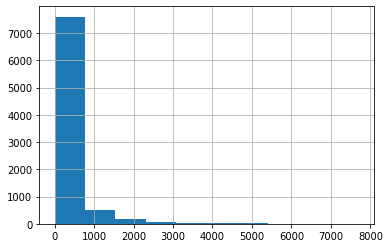

In [9]:
#line item insurance
print((scdf['Line Item Insurance (USD)'].isnull().sum()/scdf.shape[0])*100, '%\n')
print(scdf['Line Item Insurance (USD)'].describe())
scdf['Line Item Insurance (USD)'].hist()
scdf['Line Item Insurance (USD)'] = scdf['Line Item Insurance (USD)'].fillna(scdf['Line Item Insurance (USD)'].median())
print((scdf['Line Item Insurance (USD)'].isnull().sum()/scdf.shape[0])*100, '%\n')

In [10]:
scdf.dtypes

ID                                int64
Project Code                     object
PQ #                             object
PO / SO #                        object
ASN/DN #                         object
Country                          object
Managed By                       object
Fulfill Via                      object
Vendor INCO Term                 object
Shipment Mode                    object
PQ First Sent to Client Date     object
PO Sent to Vendor Date           object
Scheduled Delivery Date          object
Delivered to Client Date         object
Delivery Recorded Date           object
Product Group                    object
Sub Classification               object
Vendor                           object
Item Description                 object
Molecule/Test Type               object
Brand                            object
Dosage                           object
Dosage Form                      object
Unit of Measure (Per Pack)        int64
Line Item Quantity                int64


In [11]:
#lets remove the unnecessary variables first
scdf.drop('ID', axis=1, inplace=True)
scdf.drop('Project Code', axis=1, inplace=True)
scdf.drop('ASN/DN #', axis=1, inplace=True)           

In [12]:
print(scdf['PQ First Sent to Client Date'].value_counts())
scdf.drop(scdf[scdf['PQ First Sent to Client Date'] == 'Date Not Captured'].index, inplace = True)

print(scdf['PO Sent to Vendor Date'].value_counts())
scdf.drop(scdf[scdf['PO Sent to Vendor Date'] == 'Date Not Captured'].index, inplace = True)

scdf['Scheduled Delivery Date'] = pd.to_datetime(scdf['Scheduled Delivery Date'])
scdf['Delivered to Client Date'] = pd.to_datetime(scdf['Delivered to Client Date'])
scdf['Delivery Recorded Date'] = pd.to_datetime(scdf['Delivery Recorded Date'])

Pre-PQ Process       1918
9/11/2014             205
Date Not Captured     205
7/11/2013             173
4/30/2014             123
                     ... 
7/1/2014                1
7/23/2012               1
8/2/2011                1
6/29/2015               1
4/14/2010               1
Name: PQ First Sent to Client Date, Length: 581, dtype: int64
N/A - From RDC       5020
Date Not Captured     267
3/19/2010              78
8/29/2014              76
10/9/2014              69
                     ... 
10/1/2010               1
11/22/2007              1
3/19/2009               1
5/7/2007                1
7/28/2014               1
Name: PO Sent to Vendor Date, Length: 581, dtype: int64


In [13]:
# Important KPIs: Freight Cost, Weight, Line Item Insurance, Line Item Quantity, Pack Price
# Important Dimensions: Country, Fullfil Via, Shipment Mode, Product Group, Subclassification, Brand, Dosage Form

In [14]:
print(scdf['Freight Cost (USD)'].value_counts())
scdf.drop(scdf[scdf['Freight Cost (USD)']=='Freight Included in Commodity Cost'].index, inplace=True)
scdf.drop(scdf[scdf['Freight Cost (USD)']=='Invoiced Separately'].index, inplace=True)
scdf.drop(scdf[scdf['Freight Cost (USD)'].str.contains('See')].index, inplace=True)
scdf['Freight Cost (USD)'] = scdf['Freight Cost (USD)'].astype(float)
print(scdf['Freight Cost (USD)'].value_counts())
print(scdf.dtypes)

Freight Included in Commodity Cost    1155
Invoiced Separately                    142
9736.1                                  36
6147.18                                 27
13398.06                                16
                                      ... 
4427.52                                  1
1681.58                                  1
See ASN-10007 (ID#:23194)                1
2653.27                                  1
502.49                                   1
Name: Freight Cost (USD), Length: 5159, dtype: int64
9736.10     36
6147.18     27
13398.06    16
7329.83     12
25231.96    11
            ..
5159.34      1
3790.32      1
8527.45      1
6668.61      1
4529.67      1
Name: Freight Cost (USD), Length: 4009, dtype: int64
PQ #                                    object
PO / SO #                               object
Country                                 object
Managed By                              object
Fulfill Via                             object
Vendor INCO Term     

In [15]:
print(scdf['Weight (Kilograms)'].value_counts())
scdf.drop(scdf[scdf['Weight (Kilograms)'].str.contains('Weight')].index, inplace=True)
scdf['Weight (Kilograms)'] = scdf['Weight (Kilograms)'].astype(float)
print(scdf['Weight (Kilograms)'].value_counts())
print(scdf.dtypes)

76                            15
9                             14
Weight Captured Separately    13
21                            13
6                             13
                              ..
9248                           1
1130                           1
7682                           1
34119                          1
3869                           1
Name: Weight (Kilograms), Length: 2942, dtype: int64
76.0      15
9.0       14
6.0       13
21.0      13
52.0      12
          ..
218.0      1
3425.0     1
2698.0     1
6680.0     1
3703.0     1
Name: Weight (Kilograms), Length: 2941, dtype: int64
PQ #                                    object
PO / SO #                               object
Country                                 object
Managed By                              object
Fulfill Via                             object
Vendor INCO Term                        object
Shipment Mode                           object
PQ First Sent to Client Date            object
PO Sent to V

In [16]:
#anova
y = scdf['Freight Cost (USD)']
model = ols('y ~ C(Q("Country"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Country")
display(anova_table)

model = ols('y ~ C(Q("Fulfill Via"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Fulfill Via")
display(anova_table)

model = ols('y ~ C(Q("Shipment Mode"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Shipment Mode")
display(anova_table)

model = ols('y ~ C(Q("Product Group"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Product Group")
display(anova_table)

model = ols('y ~ C(Q("Sub Classification"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Sub Classification")
display(anova_table)

model = ols('y ~ C(Q("Brand"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Brand")
display(anova_table)

model = ols('y ~ C(Q("Dosage Form"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Freight Cost - Dosage Form")
display(anova_table)


Anova => Freight Cost - Country


,sum_sq,df,F,PR(>F)
"C(Q(""Country""))",8.986488e+10,30.0,14.053838,3.224548e-67
Residual,9.819560e+11,4607.0,NaN,NaN



Anova => Freight Cost - Fulfill Via


,sum_sq,df,F,PR(>F)
"C(Q(""Fulfill Via""))",3.241010e+09,1.0,14.061022,0.000179
Residual,1.068580e+12,4636.0,NaN,NaN



Anova => Freight Cost - Shipment Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Shipment Mode""))",5.791862e+10,3.0,88.238258,1.594916e-55
Residual,1.013902e+12,4634.0,NaN,NaN



Anova => Freight Cost - Product Group


,sum_sq,df,F,PR(>F)
"C(Q(""Product Group""))",2.787474e+08,2.0,0.602867,0.547284
Residual,1.071542e+12,4635.0,NaN,NaN



Anova => Freight Cost - Sub Classification


,sum_sq,df,F,PR(>F)
"C(Q(""Sub Classification""))",1.954408e+10,3.0,28.689299,2.251273e-18
Residual,1.052277e+12,4634.0,NaN,NaN



Anova => Freight Cost - Brand


,sum_sq,df,F,PR(>F)
"C(Q(""Brand""))",2.529497e+10,20.0,5.579742,1.604096e-14
Residual,1.046526e+12,4617.0,NaN,NaN



Anova => Freight Cost - Dosage Form


,sum_sq,df,F,PR(>F)
"C(Q(""Dosage Form""))",6.364402e+10,14.0,20.845713,3.447648e-52
Residual,1.008177e+12,4623.0,NaN,NaN


In [17]:
#anova
y = scdf['Weight (Kilograms)']
model = ols('y ~ C(Q("Country"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Country")
display(anova_table)

model = ols('y ~ C(Q("Fulfill Via"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Fulfill Via")
display(anova_table)

model = ols('y ~ C(Q("Shipment Mode"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Shipment Mode")
display(anova_table)

model = ols('y ~ C(Q("Product Group"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Product Group")
display(anova_table)

model = ols('y ~ C(Q("Sub Classification"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Sub Classification")
display(anova_table)

model = ols('y ~ C(Q("Brand"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Brand")
display(anova_table)

model = ols('y ~ C(Q("Dosage Form"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Weight - Dosage Form")
display(anova_table)


Anova => Weight - Country


,sum_sq,df,F,PR(>F)
"C(Q(""Country""))",2.222340e+10,30.0,13.017833,1.928943e-61
Residual,2.621614e+11,4607.0,NaN,NaN



Anova => Weight - Fulfill Via


,sum_sq,df,F,PR(>F)
"C(Q(""Fulfill Via""))",3.553548e+09,1.0,58.662435,2.264085e-14
Residual,2.808313e+11,4636.0,NaN,NaN



Anova => Weight - Shipment Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Shipment Mode""))",2.821230e+10,3.0,170.114267,1.267192e-104
Residual,2.561725e+11,4634.0,NaN,NaN



Anova => Weight - Product Group


,sum_sq,df,F,PR(>F)
"C(Q(""Product Group""))",2.606464e+08,2.0,2.126,0.11943
Residual,2.841242e+11,4635.0,NaN,NaN



Anova => Weight - Sub Classification


,sum_sq,df,F,PR(>F)
"C(Q(""Sub Classification""))",5.478408e+09,3.0,30.341051,2.033503e-19
Residual,2.789064e+11,4634.0,NaN,NaN



Anova => Weight - Brand


,sum_sq,df,F,PR(>F)
"C(Q(""Brand""))",6.180269e+09,20.0,5.128295,6.399453e-13
Residual,2.782046e+11,4617.0,NaN,NaN



Anova => Weight - Dosage Form


,sum_sq,df,F,PR(>F)
"C(Q(""Dosage Form""))",2.007175e+10,14.0,25.076239,9.112334e-64
Residual,2.643131e+11,4623.0,NaN,NaN


In [18]:
#anova
y = scdf['Line Item Insurance (USD)']
model = ols('y ~ C(Q("Country"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Country")
display(anova_table)

model = ols('y ~ C(Q("Fulfill Via"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Fulfill Via")
display(anova_table)

model = ols('y ~ C(Q("Shipment Mode"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Shipment Mode")
display(anova_table)

model = ols('y ~ C(Q("Product Group"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Product Group")
display(anova_table)

model = ols('y ~ C(Q("Sub Classification"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Sub Classification")
display(anova_table)

model = ols('y ~ C(Q("Brand"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Brand")
display(anova_table)

model = ols('y ~ C(Q("Dosage Form"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Insurance - Dosage Form")
display(anova_table)


Anova => L.I.Insurance - Country


,sum_sq,df,F,PR(>F)
"C(Q(""Country""))",1.654541e+08,30.0,17.472671,3.195892e-86
Residual,1.454170e+09,4607.0,NaN,NaN



Anova => L.I.Insurance - Fulfill Via


,sum_sq,df,F,PR(>F)
"C(Q(""Fulfill Via""))",7.173875e+06,1.0,20.625803,0.000006
Residual,1.612450e+09,4636.0,NaN,NaN



Anova => L.I.Insurance - Shipment Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Shipment Mode""))",1.354426e+08,3.0,140.962305,2.088483e-87
Residual,1.484182e+09,4634.0,NaN,NaN



Anova => L.I.Insurance - Product Group


,sum_sq,df,F,PR(>F)
"C(Q(""Product Group""))",2.238604e+06,2.0,3.207623,0.040542
Residual,1.617386e+09,4635.0,NaN,NaN



Anova => L.I.Insurance - Sub Classification


,sum_sq,df,F,PR(>F)
"C(Q(""Sub Classification""))",9.072895e+07,3.0,91.664868,1.262103e-57
Residual,1.528895e+09,4634.0,NaN,NaN



Anova => L.I.Insurance - Brand


,sum_sq,df,F,PR(>F)
"C(Q(""Brand""))",4.601020e+07,20.0,6.74972,9.275745e-19
Residual,1.573614e+09,4617.0,NaN,NaN



Anova => L.I.Insurance - Dosage Form


,sum_sq,df,F,PR(>F)
"C(Q(""Dosage Form""))",1.933081e+08,14.0,44.753809,1.614800e-116
Residual,1.426316e+09,4623.0,NaN,NaN


In [19]:
#anova
y = scdf['Line Item Quantity']
model = ols('y ~ C(Q("Country"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Country")
display(anova_table)

model = ols('y ~ C(Q("Fulfill Via"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Fulfill Via")
display(anova_table)

model = ols('y ~ C(Q("Shipment Mode"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Shipment Mode")
display(anova_table)

model = ols('y ~ C(Q("Product Group"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Product Group")
display(anova_table)

model = ols('y ~ C(Q("Sub Classification"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Sub Classification")
display(anova_table)

model = ols('y ~ C(Q("Brand"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Brand")
display(anova_table)

model = ols('y ~ C(Q("Dosage Form"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => L.I.Quantity - Dosage Form")
display(anova_table)


Anova => L.I.Quantity - Country


,sum_sq,df,F,PR(>F)
"C(Q(""Country""))",1.418326e+12,30.0,23.690888,2.557637e-120
Residual,9.193727e+12,4607.0,NaN,NaN



Anova => L.I.Quantity - Fulfill Via


,sum_sq,df,F,PR(>F)
"C(Q(""Fulfill Via""))",1.182685e+10,1.0,5.172462,0.022993
Residual,1.060023e+13,4636.0,NaN,NaN



Anova => L.I.Quantity - Shipment Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Shipment Mode""))",1.501780e+12,3.0,254.630165,5.860156e-153
Residual,9.110273e+12,4634.0,NaN,NaN



Anova => L.I.Quantity - Product Group


,sum_sq,df,F,PR(>F)
"C(Q(""Product Group""))",1.871973e+10,2.0,4.09531,0.016711
Residual,1.059333e+13,4635.0,NaN,NaN



Anova => L.I.Quantity - Sub Classification


,sum_sq,df,F,PR(>F)
"C(Q(""Sub Classification""))",4.601167e+11,3.0,70.009,2.832091e-44
Residual,1.015194e+13,4634.0,NaN,NaN



Anova => L.I.Quantity - Brand


,sum_sq,df,F,PR(>F)
"C(Q(""Brand""))",4.017709e+11,20.0,9.083864,1.873609e-27
Residual,1.021028e+13,4617.0,NaN,NaN



Anova => L.I.Quantity - Dosage Form


,sum_sq,df,F,PR(>F)
"C(Q(""Dosage Form""))",8.227691e+11,14.0,27.753829,4.632454e-71
Residual,9.789284e+12,4623.0,NaN,NaN


In [20]:
#anova
y = scdf['Pack Price']
model = ols('y ~ C(Q("Country"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Country")
display(anova_table)

model = ols('y ~ C(Q("Fulfill Via"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Fulfill Via")
display(anova_table)

model = ols('y ~ C(Q("Shipment Mode"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Shipment Mode")
display(anova_table)

model = ols('y ~ C(Q("Product Group"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Product Group")
display(anova_table)

model = ols('y ~ C(Q("Sub Classification"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Sub Classification")
display(anova_table)

model = ols('y ~ C(Q("Brand"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Brand")
display(anova_table)

model = ols('y ~ C(Q("Dosage Form"))', data=scdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Pack Price - Dosage Form")
display(anova_table)


Anova => Pack Price - Country


,sum_sq,df,F,PR(>F)
"C(Q(""Country""))",1.270844e+05,30.0,12.695047,1.217899e-59
Residual,1.537286e+06,4607.0,NaN,NaN



Anova => Pack Price - Fulfill Via


,sum_sq,df,F,PR(>F)
"C(Q(""Fulfill Via""))",7.091715e+04,1.0,206.326639,8.262644e-46
Residual,1.593454e+06,4636.0,NaN,NaN



Anova => Pack Price - Shipment Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Shipment Mode""))",6.656995e+04,3.0,64.356201,9.199227e-41
Residual,1.597801e+06,4634.0,NaN,NaN



Anova => Pack Price - Product Group


,sum_sq,df,F,PR(>F)
"C(Q(""Product Group""))",1.061631e+04,2.0,14.877241,3.626991e-07
Residual,1.653754e+06,4635.0,NaN,NaN



Anova => Pack Price - Sub Classification


,sum_sq,df,F,PR(>F)
"C(Q(""Sub Classification""))",2.719307e+04,3.0,25.656487,1.865123e-16
Residual,1.637178e+06,4634.0,NaN,NaN



Anova => Pack Price - Brand


,sum_sq,df,F,PR(>F)
"C(Q(""Brand""))",923715.254581,20.0,287.906697,0.0
Residual,740655.457018,4617.0,NaN,NaN



Anova => Pack Price - Dosage Form


,sum_sq,df,F,PR(>F)
"C(Q(""Dosage Form""))",8.665382e+04,14.0,18.136543,9.434559e-45
Residual,1.577717e+06,4623.0,NaN,NaN


In [21]:
data_crosstab = pd.crosstab(scdf['Dosage Form'], scdf['Vendor INCO Term'], 
margins = False) 
#print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
#print('dof=%d' % dof)
#print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

significance=0.050, p=0.000
Dependent (reject H0)


In [22]:
data_crosstab = pd.crosstab(scdf['Dosage Form'], scdf['Fulfill Via'], 
margins = False) 
#print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
#print('dof=%d' % dof)
#print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

significance=0.050, p=0.000
Dependent (reject H0)


In [23]:
data_crosstab = pd.crosstab(scdf['Dosage Form'], scdf['Shipment Mode'], 
margins = False) 
#print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
#print('dof=%d' % dof)
#print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

significance=0.050, p=0.000
Dependent (reject H0)


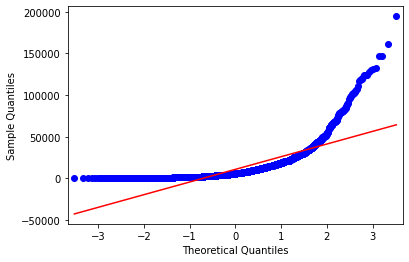

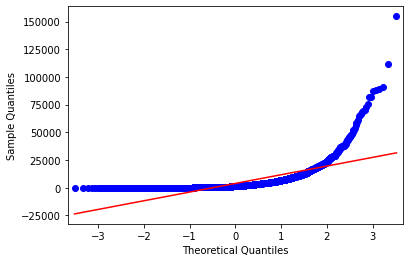

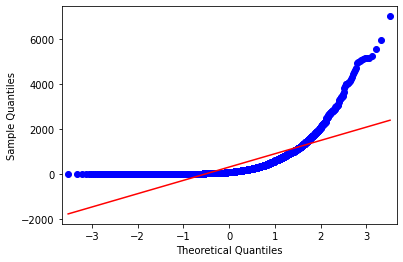

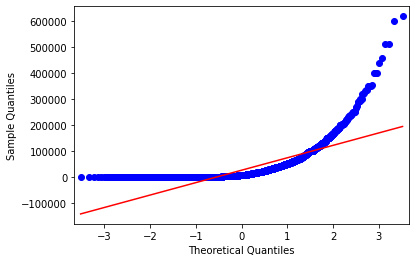

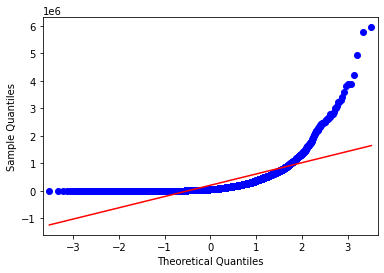

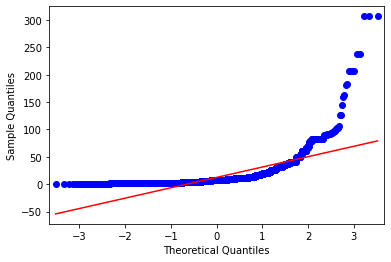

In [24]:
qqplot(scdf['Freight Cost (USD)'], line='s')
pyplot.show()

qqplot(scdf['Weight (Kilograms)'], line='s')
pyplot.show()

qqplot(scdf['Line Item Insurance (USD)'], line='s')
pyplot.show()

qqplot(scdf['Line Item Quantity'], line='s')
pyplot.show()

qqplot(scdf['Line Item Value'], line='s')
pyplot.show()

qqplot(scdf['Pack Price'], line='s')
pyplot.show()

In [ ]:
scdf.to_csv('scdf.clean.csv')